### Phantom

In [3]:
### Myocardium 
import numpy as np

# -----------------------------
# PARAMETERS
# -----------------------------
H, W, D = 2048, 2048, 500
inner_r, outer_r = 500, 750
height = 400
tilt_rad = np.deg2rad(0)
waviness_amp, waviness_freq = 2.5, 8

cx, cy, z0 = W // 2, H // 2, D // 2

# Initialize the final volume only (approx 2GB for uint8)
volume = np.random.randint(1,20, size=(H, W, D), dtype=np.uint8)

# Create 1D coordinate vectors
y_coords = (np.arange(H) - cy).reshape(H, 1)  # (H, 1)
x_coords = (np.arange(W) - cx).reshape(1, W)  # (1, W)


for z_idx in range(D):
    # Current Z relative to center
    zc = z_idx - z0
    
    # Apply rotation (tilt) to Y and Z coordinates for this slice
    # Note: Xt = Xc (no change to X in X-axis rotation)
    yt = y_coords * np.cos(tilt_rad) - zc * np.sin(tilt_rad)
    zt = y_coords * np.sin(tilt_rad) + zc * np.cos(tilt_rad)
    xt = x_coords
    
    # z_mask for this slice (zt is an (H, 1) array)
    z_slice_mask = np.abs(zt) <= height / 2  # Shape (H, 1)
    
    # Calculate cylindrical coords for the 2D plane
    # xt is (1, W), yt is (H, 1) -> r and theta become (H, W)
    r = np.sqrt(xt**2 + yt**2)
    theta = np.arctan2(yt, xt)
    
    # Wavy deformation (zt is used as a constant/vector in this 2D slice)
    noise = (np.sin(theta * waviness_freq) + np.sin(zt * 0.05)) * waviness_amp
    
    # Final Mask for this slice
    mask_2d = (
        (r >= (inner_r + noise)) & 
        (r <= (outer_r + noise)) & 
        z_slice_mask
    )
    
    # Assign values
    if np.any(mask_2d):
        num_pixels = mask_2d.sum()
        volume[mask_2d, z_idx] = np.random.uniform(150, 255, size=num_pixels).astype(np.uint8)

import nibabel as nib

nii = nib.Nifti1Image(volume, affine=np.diag([0.27,0.27,1,1]))
nib.save(nii, "myocardium.nii.gz")

In [4]:
### Endocardium
import numpy as np

# -----------------------------
# PARAMETERS
# -----------------------------
H, W, D = 2048, 2048, 500
inner_r, outer_r = 250, 300
height = 300
tilt_rad = np.deg2rad(0)
waviness_amp, waviness_freq = 20, 30

cx, cy, z0 = W // 2, H // 2, D // 2

# Initialize the final volume only (approx 2GB for uint8)
volume = np.random.randint(1,20, size=(H, W, D), dtype=np.uint8)

# Create 1D coordinate vectors
y_coords = (np.arange(H) - cy).reshape(H, 1)  # (H, 1)
x_coords = (np.arange(W) - cx).reshape(1, W)  # (1, W)

print("Starting slice-by-slice processing...")

for z_idx in range(D):
    # Current Z relative to center
    zc = z_idx - z0
    
    # Apply rotation (tilt) to Y and Z coordinates for this slice
    # Note: Xt = Xc (no change to X in X-axis rotation)
    yt = y_coords * np.cos(tilt_rad) - zc * np.sin(tilt_rad)
    zt = y_coords * np.sin(tilt_rad) + zc * np.cos(tilt_rad)
    xt = x_coords
    
    # z_mask for this slice (zt is an (H, 1) array)
    z_slice_mask = np.abs(zt) <= height / 2  # Shape (H, 1)
    
    # Calculate cylindrical coords for the 2D plane
    # xt is (1, W), yt is (H, 1) -> r and theta become (H, W)
    r = np.sqrt(xt**2 + yt**2)
    theta = np.arctan2(yt, xt)
    
    # Wavy deformation (zt is used as a constant/vector in this 2D slice)
    noise = (np.sin(theta * waviness_freq) + np.sin(zt * 0.05)) * waviness_amp
    
    # Final Mask for this slice
    mask_2d = (
        (r >= (inner_r + noise)) & 
        (r <= (outer_r + noise)) & 
        z_slice_mask
    )
    
    # Assign values
    if np.any(mask_2d):
        num_pixels = mask_2d.sum()
        volume[mask_2d, z_idx] = np.random.uniform(150, 255, size=num_pixels).astype(np.uint8)

import nibabel as nib

nii = nib.Nifti1Image(volume, affine=np.diag([0.27,0.27,1,1]))
nib.save(nii, "endocardium.nii.gz")


Starting slice-by-slice processing...


### Segmentation results plots - Dice and IoU plots

### Here we use the json file created by the metric.py file. Image indexes are mapped for linux pattern


In [ ]:
### Normalised x-axis plots for Dice and IoU through z-axis. Un-nonrmalised x-axis plots are in the matrics.py

import numpy as np
import matplotlib.pyplot as plt
import json
import os
import matplotlib as mpl

mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.size'] = 12

jason_path = "/Users/dbattagodage/Desktop/Datasets/Model_results/IF_352_6img_results/nnUNetTrainerUMambaEncNoAMP__nnUNetPlans__3d_fullres/all_segs_no_bg_linux/Evaluation_summary_perslice.json"
folder_pred = "/Users/dbattagodage/Desktop/Datasets/Model_results/IF_352_6img_results/nnUNetTrainerUMambaEncNoAMP__nnUNetPlans__3d_fullres/all_segs_no_bg_linux"
img_map = {'0001':'15Ps','0006':'19Ps','0002':'E9.5','0005':'10Ps','0003':'8Ps','0004':'13Ps'}
with open(jason_path, 'r') as f:
    data = json.load(f)

matric_per_case = data['metric_per_case']

label_names = ['background',"Myocardium","Endocardium","Lumen","ECM"]
start_end = {'1':[23,549],'2':[0,697],'3':[21,317],'4':[30,375],'5':[13,367],'6':[19,595]}

for ID,label in enumerate([1,2,3,4,5]):
    Dice=[]
    IoU=[]
    max_length =0
    img_IDs=[]
    for imgs in matric_per_case:
        Dice.append(imgs['metrics'][str(label)]['Dice_through_z_axis'])
        IoU.append(imgs['metrics'][str(label)]['IoU_through_z_axis'])
        max_length = max(max_length,len(imgs['metrics'][str(label)]['Dice_through_z_axis']))
        img_IDs.append(imgs['reference_file'].split("/")[-1].split("_")[2].split(".")[0])
    
    fig1,ax1 = plt.subplots(figsize=(10,5), dpi = 300)
    fig2,ax2 = plt.subplots(figsize=(10,5), dpi = 300)

    for r in range(len(Dice)):
        n = len(Dice[r])
        # offset = (max_length - n) // 2
        # x = np.arange(offset, offset + n)  # center the shorter curve
        x = np.linspace(0, 1, n)  
        ax1.plot(x,Dice[r],label=img_map[img_IDs[r]])
        ax1.scatter([start_end[str(int(img_IDs[r]))][0]/n, start_end[str(int(img_IDs[r]))][1]/n], \
                    [Dice[r][start_end[str(int(img_IDs[r]))][0]],Dice[r][start_end[str(int(img_IDs[r]))][1]]], color='black', s=100)
        
        ax2.plot(x,IoU[r],label=img_map[img_IDs[r]])
        ax2.scatter([start_end[str(int(img_IDs[r]))][0]/n, start_end[str(int(img_IDs[r]))][1]/n], \
                    [IoU[r][start_end[str(int(img_IDs[r]))][0]],IoU[r][start_end[str(int(img_IDs[r]))][1]]], color='black', s=100)
    ax1.set_title(f'Dice score through z-axis for {label_names[ID]}')
    ax1.set_xlabel('Z-axis (slices)')
    ax1.set_ylabel('Dice Score')
    ax1.legend()
    ax2.set_title(f'IoU through z-axis for {label_names[ID]}')
    ax2.set_xlabel('Z-axis (slices)')
    ax2.set_ylabel('IoU Score')
    ax2.legend()
    ax1.grid(True)
    ax2.grid(True)
    fig1.tight_layout()
    fig2.tight_layout()
    fig1.savefig(os.path.join(folder_pred,"Eval_plots",f'All_Dice_through_z_axis_label_{label}_normalised_x.pdf'), dpi =300)
    fig2.savefig(os.path.join(folder_pred,"Eval_plots",f'All_IoU_through_z_axis_label_{label}_normalised_x.pdf'), dpi =300)
    plt.close(fig1)
    plt.close(fig2)

In [ ]:
## IDEAL plots

import numpy as np
import matplotlib.pyplot as plt
import os
import json

folder_pred = "/home/cellsmb/Desktop/Dinuka/Image_Analysis/Model_results/Model_results/IF_352_6img_results/all_segs_bg"
label_names = ['background',"Myocardium","Endocardium","Lumen","ECM"]
start_end = {'1':[23,549],'2':[0,697],'3':[21,317],'4':[30,375],'5':[13,367],'6':[19,595]}
json_path = "/home/cellsmb/Desktop/Dinuka/Image_Analysis/Model_results/Model_results/IF_352_6img_results/all_segs_bg/Evaluation_summary_perslice.json"

with open(json_path, 'r') as f:
    results = json.load(f)['metric_per_case']


Dice=[]
img_IDs=[]
max_length=0
for imgs in results:
    Dice.append(imgs['metrics']["1"]['Dice_through_z_axis'])
    img_IDs.append(imgs['reference_file'].split("/")[-1].split("_")[2].split(".")[0])
    max_length = max(max_length, len(Dice[-1]))

fig1,ax1 = plt.subplots(figsize=(15,10))
fig2,ax2 = plt.subplots(figsize=(15,10))
for r in range(len(Dice)):
    n = len(Dice[r])
    x = np.linspace(0, 1, n)  
    y = np.zeros(n)
    start_end_values = start_end[str(int(img_IDs[r]))]
    y[start_end_values[0]:start_end_values[1]+1] = 1
    ax1.plot(x,y, label=f"Image {img_IDs[r]}")

    offset = (max_length - n) // 2
    x = np.arange(offset, offset + n)  # center the shorter curve
    ax2.plot(x,y, label=f"Image {img_IDs[r]}")

ax1.set_title('Ideal Situation for all tissues')
ax1.set_xlabel('Z-axis (slices)')
ax1.set_ylabel('Tissue Presence (1=Present, 0=Absent)')
ax1.legend()
fig1.savefig(os.path.join(folder_pred,"Eval_plots",'Ideal_plots_normalised_x.pdf'), dpi=300)

ax2.set_title('Ideal Situation for all tissues')
ax2.set_xlabel('Z-axis (slices)')
ax2.set_ylabel('Tissue Presence (1=Present, 0=Absent)')
ax2.legend()
fig2.savefig(os.path.join(folder_pred,"Eval_plots",'Ideal_plots_normalised_x.pdf'), dpi=300)

plt.show()

## Evaluation matrices analysis


### heat maps

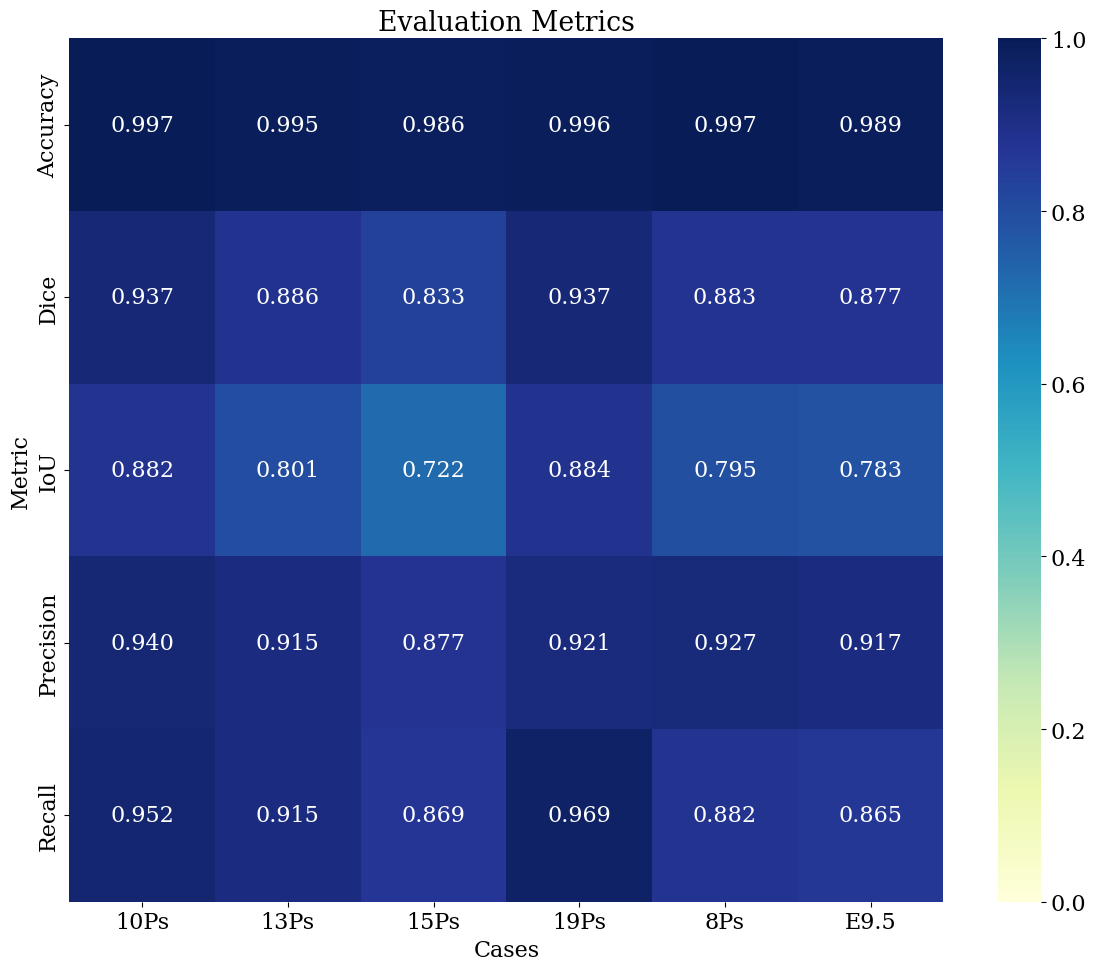

In [1]:
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.size'] = 16

json_path = "/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/new_patchSize/nnUNetTrainer__nnUNetPlans__3d_fullres"
img_map ={"0001":"15Ps", "0002":"19Ps","0003":"E9.5", "0004":"10Ps","0005":"8Ps","0006":"13Ps"}
class_mapping = ["Myocardium", "Endocardium", "Lumen", "ECM"]
def find_metric_heatmap(json_path, just_foreground=True, only_dice_and_iou=False):
    metrics_list = []
    case = []
    for folds in os.listdir(json_path):
        if os.path.isdir(os.path.join(json_path, folds)):
            if folds.startswith('fold_'):
                json_file_path = os.path.join(json_path, folds, 'validation', 'summary.json')

                with open(json_file_path, 'r') as f:
                    data = json.load(f)

                metric_class=data['metric_per_case']
                for r in range(len(metric_class)):
                    case_id = img_map[metric_class[r]["reference_file"].split('/')[-1].split('_')[2][:-7]]
                    if not just_foreground:
                        print("Currently only just_foreground=True is supported.")
                        for i in range(1, 5):
                            TP = metric_class[r]["metrics"][str(i)]["TP"]
                            TN = metric_class[r]["metrics"][str(i)]["TN"]
                            FP = metric_class[r]["metrics"][str(i)]["FP"]
                            FN = metric_class[r]["metrics"][str(i)]["FN"]

                            dice = metric_class[r]["metrics"][str(i)]["Dice"]
                            iou = metric_class[r]["metrics"][str(i)]["IoU"]

                            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
                            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
                            accuracy = (TP + TN) / (TP + TN + FP + FN)

                            metrics_list.append({
                                "Case": case_id,
                                "Metric": f"{class_mapping[i-1]}_Dice", "Value": dice
                            })
                            metrics_list.append({
                                "Case": case_id,
                                "Metric": f"{class_mapping[i-1]}_IoU", "Value": iou
                            })
                            if not only_dice_and_iou:
                                metrics_list.append({
                                    "Case": case_id,
                                    "Metric": f"{class_mapping[i-1]}_Precision", "Value": precision
                                })
                                metrics_list.append({
                                    "Case": case_id,
                                    "Metric": f"{class_mapping[i-1]}_Recall", "Value": recall
                                })
                                metrics_list.append({
                                    "Case": case_id,
                                    "Metric": f"{class_mapping[i-1]}_Accuracy", "Value": accuracy
                                })
                    else:
                        TP = sum([metric_class[r]["metrics"][str(i)]["TP"] for i in range(1,5)])
                        TN = sum([metric_class[r]["metrics"][str(i)]["TN"] for i in range(1,5)])
                        FP = sum([metric_class[r]["metrics"][str(i)]["FP"] for i in range(1,5)])
                        FN = sum([metric_class[r]["metrics"][str(i)]["FN"] for i in range(1,5)])

                        dice = np.mean([metric_class[r]["metrics"][str(i)]["Dice"] for i in range(1,5)])
                        iou =  np.mean([metric_class[r]["metrics"][str(i)]["IoU"] for i in range(1,5)])

                        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
                        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
                        accuracy = (TP + TN) / (TP + TN + FP + FN)

                        metrics_list.append({
                                "Case": case_id,
                                "Metric": "Dice", "Value": dice
                            })
                        metrics_list.append({
                            "Case": case_id,
                            "Metric": "IoU", "Value": iou
                        })
                        if not only_dice_and_iou:
                            metrics_list.append({
                                "Case": case_id,
                                "Metric": "Precision", "Value": precision
                            })
                            metrics_list.append({
                                "Case": case_id,
                                "Metric": "Recall", "Value": recall
                            })
                            metrics_list.append({
                                "Case": case_id,
                                "Metric": "Accuracy", "Value": accuracy
                            })
    return metrics_list, case

metrics_list, case = find_metric_heatmap(json_path, just_foreground=True, only_dice_and_iou=False)
df = pd.DataFrame(metrics_list)
# Pivot: rows = metrics, cols = cases, values = Value
df_pivot = df.pivot(index="Metric", columns="Case", values="Value")

# Sort columns
df_pivot = df_pivot.sort_index(axis=1)

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df_pivot, annot=True, fmt=".3f", cmap="YlGnBu", vmin=0, vmax=1)
plt.ylabel("Metric")
plt.xlabel("Cases")
plt.title("Evaluation Metrics")
plt.tight_layout()
plt.savefig(os.path.join(json_path, 'Evaluation_Metrics_Heatmap_3D_NNUnet.pdf'), dpi=300)
plt.show()

In [1]:
## Big heatmap for all folds, all classes and all models

import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'times new roman'
mpl.rcParams['font.size'] = 14


# def find_metric_heatmap(json_path, exp_name):
#     Dice_list = []
#     Iou_list = []

#     for folds in os.listdir(json_path):
#         if os.path.isdir(os.path.join(json_path, folds)) and folds.startswith('fold_'):

#             json_file_path = os.path.join(json_path, folds, 'validation', 'summary.json')

#             with open(json_file_path, 'r') as f:
#                 data = json.load(f)

#             metric_mean = data['mean']

#             for i in range(1, 5): 
#                 Dice_list.append({
#                     "Experiment": exp_name,     
#                     "Fold": folds,              
#                     "Class": class_mapping[i-1],
#                     "Value": metric_mean[str(i)]["Dice"] 
#                 })

#                 Iou_list.append({
#                     "Experiment": exp_name,
#                     "Fold": folds,
#                     "Class": class_mapping[i-1],
#                     "Value": metric_mean[str(i)]["IoU"] 
#                 })

#     return Dice_list, Iou_list
##################
def find_metric_heatmap(json_path, exp_name):
    Dice_list = []
    Iou_list = []

    for folds in os.listdir(json_path):
        if os.path.isdir(os.path.join(json_path, folds)) and folds.startswith('fold_'):

            json_file_path = os.path.join(json_path, folds, 'validation', 'summary.json')

            with open(json_file_path, 'r') as f:
                data = json.load(f)

            metric_mean = data.get('mean', {})

            for i in range(1, 5):
                class_metrics = metric_mean.get(str(i), {})

                dice_value = class_metrics.get("Dice", np.nan)
                iou_value  = class_metrics.get("IoU", np.nan)

                Dice_list.append({
                    "Experiment": exp_name,
                    "Fold": folds,
                    "Class": class_mapping[i-1],
                    "Value": dice_value
                })

                Iou_list.append({
                    "Experiment": exp_name,
                    "Fold": folds,
                    "Class": class_mapping[i-1],
                    "Value": iou_value
                })

    return Dice_list, Iou_list
#################

def return_folder_paths(main_path, subfolder):
    folder_path = os.path.join(main_path, subfolder)
    results = []

    if os.path.isdir(folder_path) and subfolder.startswith('nnUNetTrainer'):
        results.append(folder_path)

    if os.path.isdir(folder_path):
        for sub in os.listdir(folder_path):
            results.extend(return_folder_paths(folder_path, sub))

    return results


path = "/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results"
class_mapping = ["Myo", "Endo", "Lumen", "ECM"]


all_folders = []

for folder in os.listdir(path):
    all_folders.extend(return_folder_paths(path, folder))

for r in all_folders:
    print(r)



/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/nnUNetTrainerSwinUMambaScratch__nnUNetPlans__2d
/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/nnUNetTrainerSwinUMamba__nnUNetPlans__2d
/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/new_patchSize/nnUNetTrainer__nnUNetPlans__3d_fullres
/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/new_patchSize/nnUNetTrainerUMambaEncNoAMP__nnUNetPlans__3d_fullres
/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/new_patchSize/nnUNetTrainerUMambaEncNoAMP__nnUNetPlans__2d
/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/two_labels/nnUNetTrainerUMambaEncNoAMP__nnUNetPlans__3d_fullres
/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/nnUNetTrainerUMambaEncNoAMP__nnUNetPlans__3d_fullres
/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/nnUNetTrainerUMambaEncNoAMP__nnUNetPlans__2d


In [2]:
all_folders = [all_folders[1],all_folders[0],all_folders[7],all_folders[4],all_folders[6],all_folders[3], all_folders[2], all_folders[5]]

In [4]:
for r in all_folders:
    print(r)

/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/nnUNetTrainerSwinUMamba__nnUNetPlans__2d
/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/nnUNetTrainerSwinUMambaScratch__nnUNetPlans__2d
/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/nnUNetTrainerUMambaEncNoAMP__nnUNetPlans__2d
/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/new_patchSize/nnUNetTrainerUMambaEncNoAMP__nnUNetPlans__2d
/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/nnUNetTrainerUMambaEncNoAMP__nnUNetPlans__3d_fullres
/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/new_patchSize/nnUNetTrainerUMambaEncNoAMP__nnUNetPlans__3d_fullres
/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/new_patchSize/nnUNetTrainer__nnUNetPlans__3d_fullres
/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/two_labels/nnUNetTrainerUMambaEncNoAMP__nnUNetPlans__3d_fullres


/var/folders/s9/h885szvn1yj9v042sc1yjsb80000gr/T/ipykernel_35755/3653693999.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_labels = annot_labels.applymap(


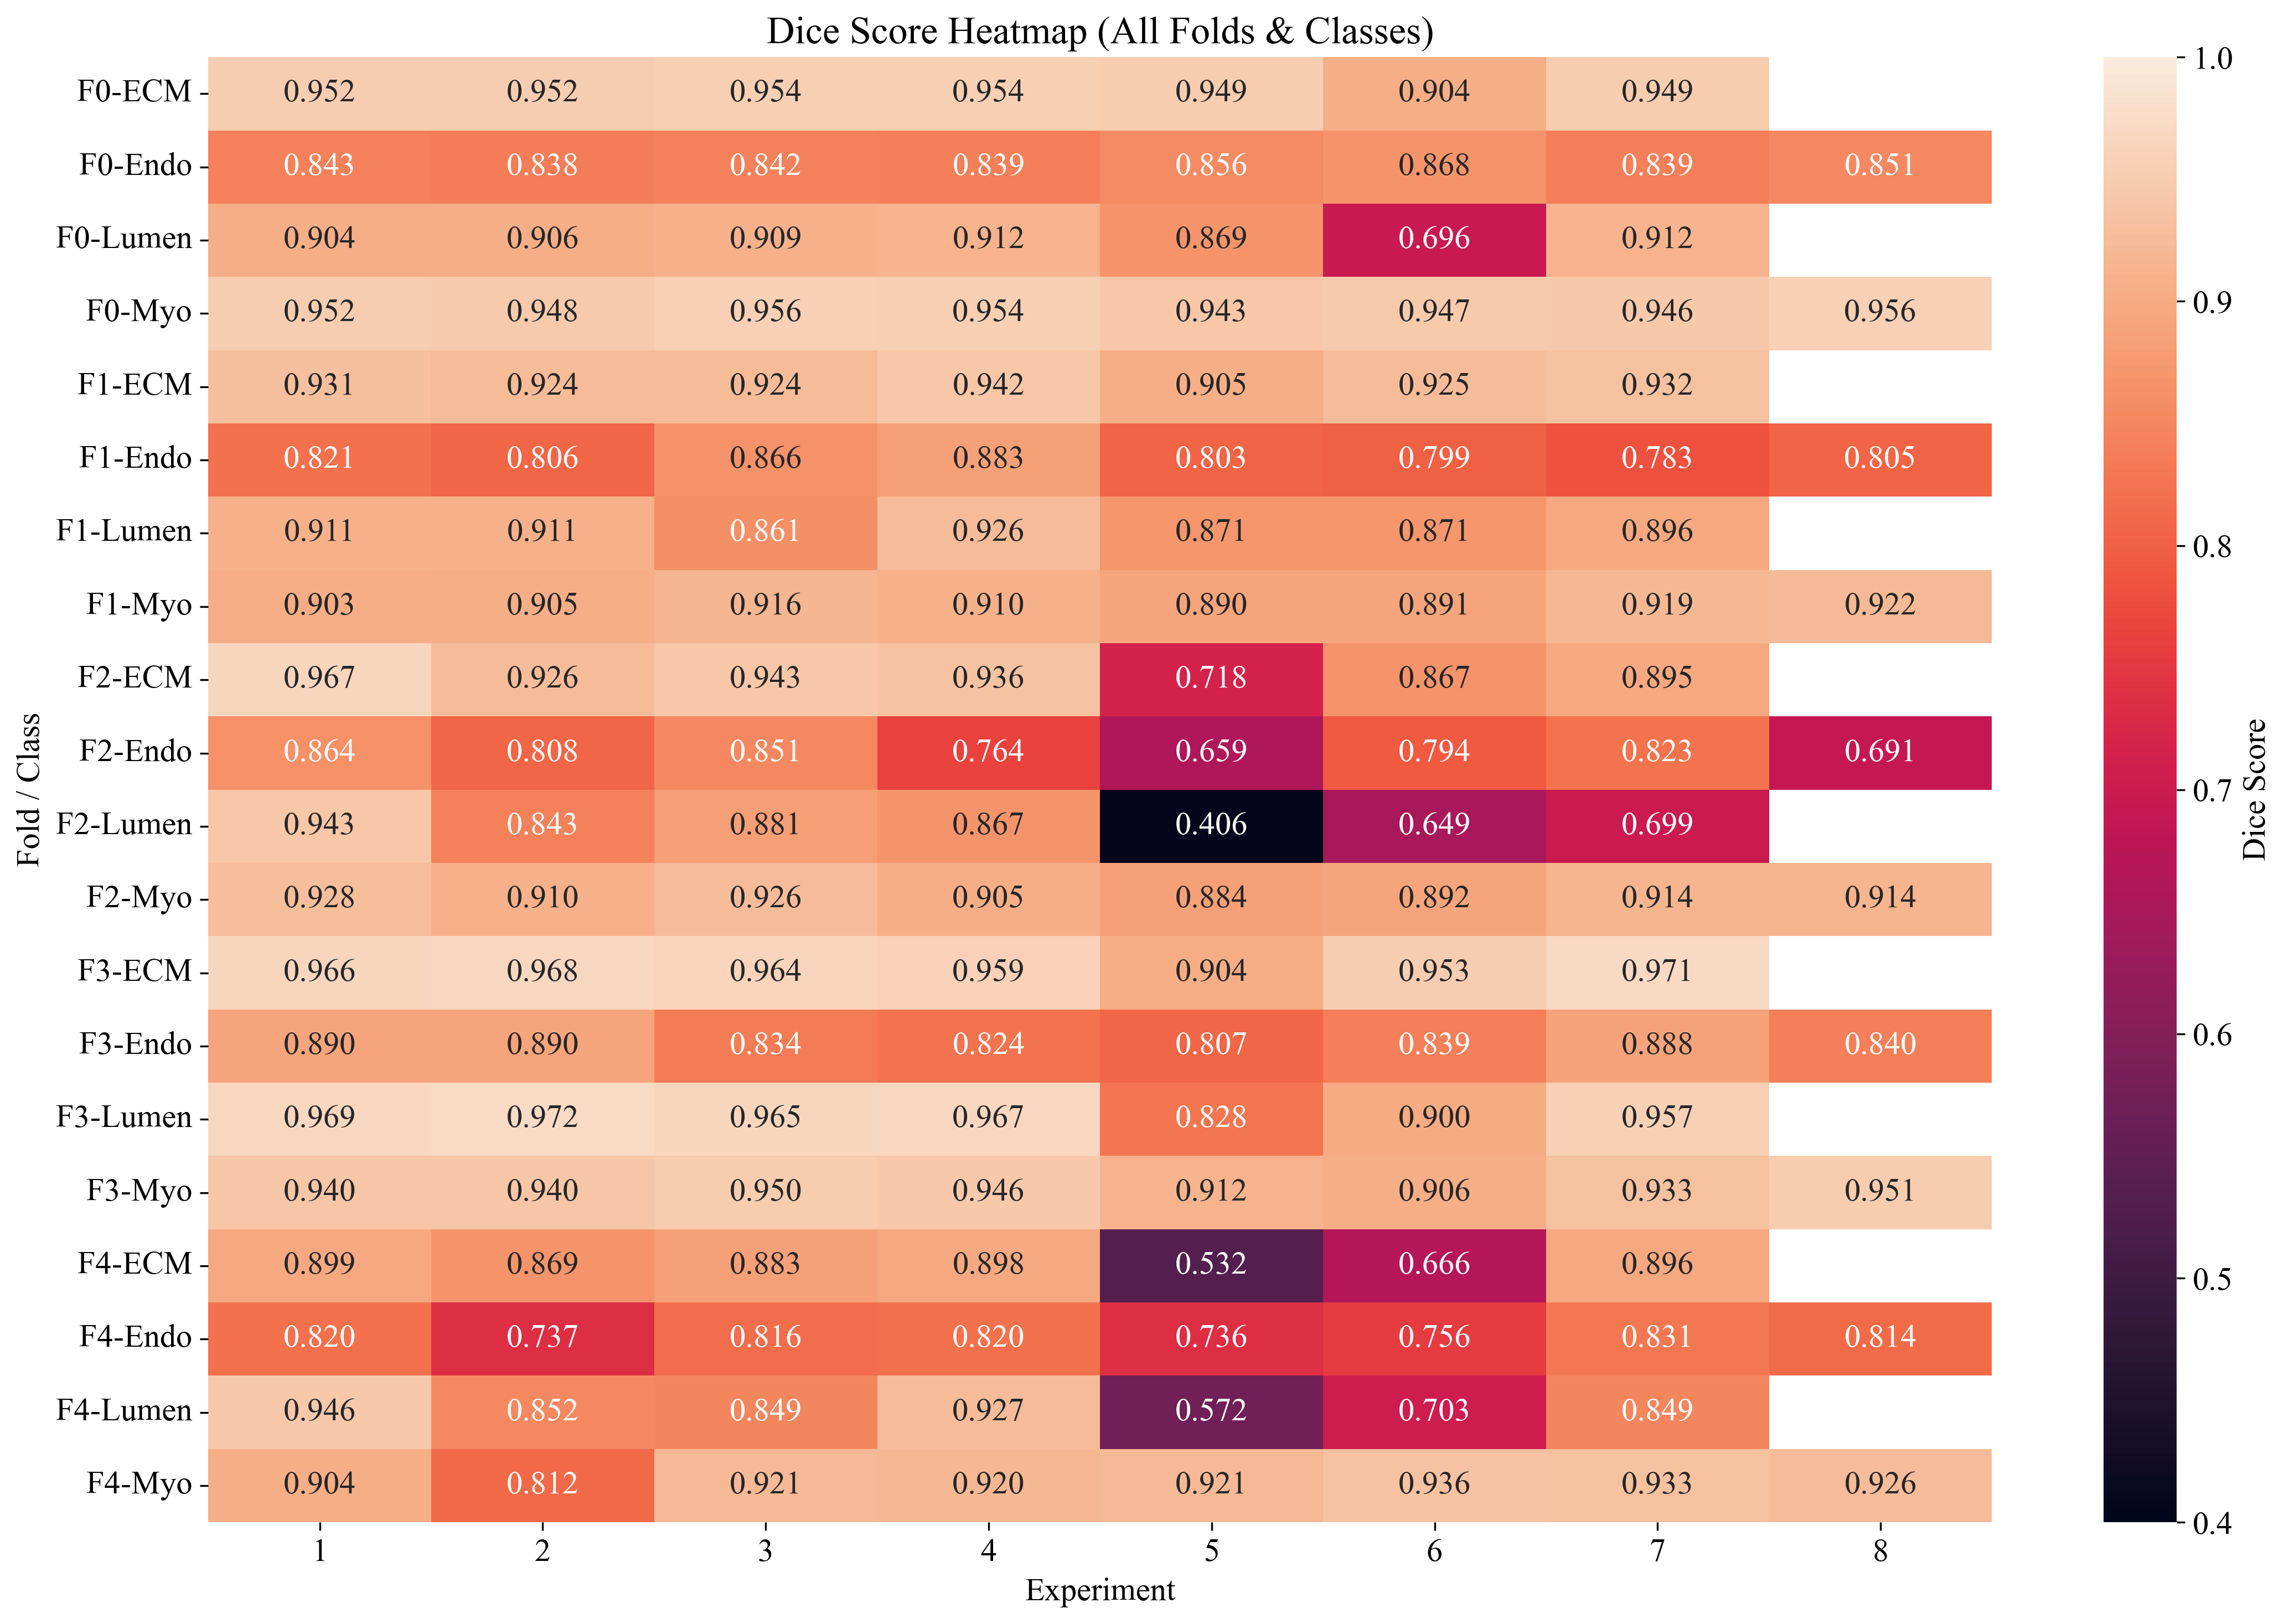

In [3]:
all_dice = []
r=1
for f in all_folders:
    dice_list, _ = find_metric_heatmap(f, str(r))
    all_dice.extend(dice_list)
    r+=1

df = pd.DataFrame(all_dice)

df["Fold"] = df["Fold"].str.replace("fold_", "F", regex=False)

df = df.set_index(["Fold", "Class"])

df_pivot = df.pivot_table(
    index=["Fold", "Class"],
    columns="Experiment",
    values="Value"
)

df_pivot = df_pivot.sort_index(level=[0, 1]).sort_index(axis=1)
##################
annot_labels = df_pivot.copy()

annot_labels = annot_labels.applymap(
    lambda x: "N/A" if pd.isna(x) else f"{x:.3f}"
)

plt.figure(figsize=(15, 10), dpi=300)

sns.heatmap(
    df_pivot,
    annot=annot_labels,
    fmt="",
    # cmap="rocket",
    vmin=0.4,
    vmax=1,
    # mask=df_pivot.isna(),
    cbar_kws={"label": "Dice Score"}
)

plt.xlabel("Experiment")
plt.ylabel("Fold / Class")
plt.title("Dice Score Heatmap (All Folds & Classes)")
plt.tight_layout()
plt.savefig('Dice_Heatmap_All_Folds_Classes.pdf', format='pdf', dpi=300)
plt.show()

##################

# plt.figure(figsize=(15, 10), dpi=300)
# sns.heatmap(
#     df_pivot,
#     annot=True,
#     fmt=".3f",
#     cmap="YlGnBu",
#     vmin=0,
#     vmax=1
# )

# plt.xlabel("Experiment")
# plt.ylabel("Fold Class")
# plt.title("Dice Score Heatmap (All Folds & Classes)")
# plt.tight_layout()
# plt.savefig('Dice_Heatmap_All_Folds_Classes.pdf', format='pdf', dpi=300)
# plt.show()


### bar plots

In [ ]:
# Bar plots for Dice and IoU for each image over different trainers.

import numpy as np
import os
import matplotlib.pyplot as plt 
import matplotlib as mpl
import json

path = "/Users/dbattagodage/Desktop/Datasets/Model_results/IF_352_6img_results"
img_map = {'0001':'15Ps','0002':'19Ps','0003':'E9.5','0004':'10Ps','0005':'8Ps','0006':'13Ps'}
dice_over_trainers = {}
IoU_over_trainers = {}

mpl.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.size'] = 12

for value in img_map.values():
    dice_over_trainers[value] = {"Myocardium":{}, "Endocardium":{}, "Lumen":{}, "ECM":{}}
    IoU_over_trainers[value] = {"Myocardium":{}, "Endocardium":{}, "Lumen":{}, "ECM":{}}
    for trainer in os.listdir(path):
        if trainer.startswith("nnUNet"):
            trainer = trainer.split("__")[0][13:]+"_"+trainer.split("__")[-1]
            dice_over_trainers[value]["Myocardium"][trainer] = 0
            dice_over_trainers[value]["Endocardium"][trainer] = 0
            dice_over_trainers[value]["Lumen"][trainer] = 0
            dice_over_trainers[value]["ECM"][trainer] = 0
            
            IoU_over_trainers[value]["Myocardium"][trainer] = 0
            IoU_over_trainers[value]["Endocardium"][trainer] = 0
            IoU_over_trainers[value]["Lumen"][trainer] = 0
            IoU_over_trainers[value]["ECM"][trainer] = 0

def read_summary(summary_file):
    data = {}
    with open(summary_file, 'r') as f:
        summary = json.load(f)
    number_of_cases = len(summary["metric_per_case"]) 
    for case_id in range(number_of_cases):
        case_ = summary["metric_per_case"][case_id]
        case_name = img_map[case_["reference_file"].split("/")[-1].split("_")[-1].split(".")[0]]
        data[case_name] = {
            "Myocardium": {
                "Dice": case_["metrics"]["1"]["Dice"],
                "IoU": case_["metrics"]["1"]["IoU"]
            },
            "Endocardium": {
                "Dice": case_["metrics"]["2"]["Dice"],
                "IoU": case_["metrics"]["2"]["IoU"]
            },
            "Lumen": {
                "Dice": case_["metrics"]["3"]["Dice"],
                "IoU": case_["metrics"]["3"]["IoU"]
            },
            "ECM": {
                "Dice": case_["metrics"]["4"]["Dice"],
                "IoU": case_["metrics"]["4"]["IoU"]
            }
        }
    return data


for trainer in os.listdir(path):
     if trainer.startswith("nnUNet"):
        trainer_name = trainer.split("__")[0][13:]+"_"+trainer.split("__")[-1]
        trainer_path = os.path.join(path, trainer)
        for fold in os.listdir(trainer_path):
            if fold.startswith('fold_'):
                summary_file = os.path.join(trainer_path, fold,"validation", "summary.json")
                data = read_summary(summary_file)
                for img_name in data.keys():
                    dice_over_trainers[img_name]["Myocardium"][trainer_name] = data[img_name]["Myocardium"]["Dice"]
                    dice_over_trainers[img_name]["Endocardium"][trainer_name] = data[img_name]["Endocardium"]["Dice"]
                    dice_over_trainers[img_name]["Lumen"][trainer_name] = data[img_name]["Lumen"]["Dice"]
                    dice_over_trainers[img_name]["ECM"][trainer_name] = data[img_name]["ECM"]["Dice"]

                    IoU_over_trainers[img_name]["Myocardium"][trainer_name] = data[img_name]["Myocardium"]["IoU"]
                    IoU_over_trainers[img_name]["Endocardium"][trainer_name] = data[img_name]["Endocardium"]["IoU"]
                    IoU_over_trainers[img_name]["Lumen"][trainer_name] = data[img_name]["Lumen"]["IoU"]
                    IoU_over_trainers[img_name]["ECM"][trainer_name] = data[img_name]["ECM"]["IoU"]
tissues = ["Myocardium", "Endocardium", "Lumen", "ECM"]

# Create a folder for plots
plot_dir = os.path.join(path, "dice_plots")
os.makedirs(plot_dir, exist_ok=True)

for img_name, tissue_dict in dice_over_trainers.items():

    # Extract trainer names (same for all tissues)
    trainers = list(tissue_dict["Myocardium"].keys())
    num_trainers = len(trainers)
    num_tissues = len(tissues)

    # Prepare bar positions
    x = np.arange(num_tissues)
    width = 0.8 / num_trainers  # shrink width based on #trainers

    fig, ax = plt.subplots(figsize=(12, 6),dpi=300)

    # Plot each trainer
    for idx, trainer in enumerate(trainers):
        dice_values = [tissue_dict[t][trainer] for t in tissues]

        ax.bar(
            x + idx * width,
            dice_values,
            width,
            label=trainer
        )
        for i, v in enumerate(dice_values):
            ax.text(
                x[i] + idx * width,   # x-position of bar
                v + 0.01,             # y-position (slightly above bar)
                f"{v:.3f}",           # format value
                ha='center', 
                va='bottom',
                fontsize=9,
                rotation=0
            )

    # Formatting
    ax.set_title(f"Dice Score Comparison for {img_name}", fontsize=16)
    ax.set_ylabel("Dice Score", fontsize=14)
    ax.set_xticks(x + width * (num_trainers - 1) / 2)
    ax.set_xticklabels(tissues, fontsize=12)
    ax.set_ylim(0, 1.1)
    ax.legend(title="Trainer", fontsize=10)

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f"{img_name}_dice_barplot.png"))
    plt.show()

### mean and std of each score over all folds

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt 
import matplotlib as mpl
import json

path = "/Users/dbattagodage/Desktop/Dataset/Model_results/IF_352_6img_results/new_patchSize/nnUNetTrainerUMambaEncNoAMP__nnUNetPlans__3d_fullres"

def read_summary(summary_file):
    with open(summary_file, 'r') as f:
        summary = json.load(f)
    foreground_mean = summary["foreground_mean"]
    return foreground_mean["Dice"], foreground_mean["IoU"]

Dice, IoU = [], []
for folder in os.listdir(path):
    if folder.startswith("fold_"):
        summary_file = os.path.join(path, folder,"validation", "summary.json")
        dice, iou = read_summary(summary_file)
        Dice.append(dice)
        IoU.append(iou)
        # print(f"{folder} - Dice: {dice}, IoU: {iou}")
print("Average Dice:", np.round(np.mean(Dice), 2))
print("Average IoU:", np.round(np.mean(IoU), 2))
print("Dice std:", np.round(np.std(Dice), 2))
print("IoU std:", np.round(np.std(IoU), 2))

Average Dice: 0.84
Average IoU: 0.73
Dice std: 0.05
IoU std: 0.07
